In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from ast import literal_eval

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm
import os


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
stocks = ['9064', '9061', '9265']

In [3]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        try:
            scores.append(np.mean(row[column]))
        except:
            scores.append(np.mean(np.array(literal_eval(row[column])).astype(np.float64)))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

In [4]:
dfs = {}
dfs_test = {}
dfs_reg = {}
dfs_reg_test = {}
data_dir='../gaussian_filter/data_gdf'
for stock in stocks:
    r = 1.0
    s = 0.1
    gdf_filename = 'gdf_{}_len{}_r{}_s{}_K50'.format(stock, data_length, r, s)
    reg_filename = '{}'.format(stock)
    print(gdf_filename)
    dfs[stock], dfs_test[stock] = lob.load_prepared_data(
        gdf_filename, data_dir=data_dir, cv=False, length=data_length)
    dfs_reg[stock], dfs_reg_test[stock] = lob.load_prepared_data(
        reg_filename, data_dir='../gaussian_filter/data', cv=False, length=data_length)

gdf_9064_len10000_r1.0_s0.1_K50
gdf_9061_len10000_r1.0_s0.1_K50
gdf_9265_len10000_r1.0_s0.1_K50


In [5]:
df = dfs[stock]
feature_columns = ['gdf_24', 'gdf_25']
res = {}
for C in [1, 10, 100, 1000, 1100]:
    for g in [0.1, 1, 2, 5]:
        clf = SVC(kernel='rbf', C=C, gamma=g)
        scores = model.validate_model(clf, df[feature_columns], df['mid_price_indicator'])
        df_score = pd.DataFrame(scores)
        res['C{}-g{}'.format(C, g)] = np.mean(df_score['matthews'].values)
res

{'C1-g0.1': 0.0,
 'C1-g1': 0.0,
 'C1-g2': 0.0,
 'C1-g5': 0.0,
 'C10-g0.1': 0.0,
 'C10-g1': -0.0016735524007341954,
 'C10-g2': 0.011859889408768403,
 'C10-g5': 0.014220197155367844,
 'C100-g0.1': -0.0012773019087180559,
 'C100-g1': 0.0018456173092746846,
 'C100-g2': 0.013484966456180431,
 'C100-g5': 0.019935302854631534,
 'C1000-g0.1': 0.0028234844520852354,
 'C1000-g1': 0.021747720434275628,
 'C1000-g2': 0.028951089740437728,
 'C1000-g5': 0.026983112262272794,
 'C1100-g0.1': 0.013471772497140296,
 'C1100-g1': 0.02340529889494084,
 'C1100-g2': 0.029753988133806156,
 'C1100-g5': 0.02519346929323265}

In [6]:
df = dfs[stock]
feature_columns = ['gdf_16', 'gdf_33']
res = {}
for C in [1000, 1100, 1500, 10000]:
    for g in [0.20, 0.25, 0.30]:
        clf = SVC(kernel='rbf', C=1000, gamma=g)
        scores = model.validate_model(clf, df[feature_columns], df['mid_price_indicator'])
        df_score = pd.DataFrame(scores)
        res['C{}-g{}'.format(C, g)] = np.mean(df_score['matthews'].values)
res

{'C1000-g0.2': 0.0036247530910379863,
 'C1000-g0.25': 0.00394393276915757,
 'C1000-g0.3': 0.0036247530910379863,
 'C1100-g0.2': 0.0036247530910379863,
 'C1100-g0.25': 0.00394393276915757,
 'C1100-g0.3': 0.0036247530910379863,
 'C1500-g0.2': 0.0036247530910379863,
 'C1500-g0.25': 0.00394393276915757,
 'C1500-g0.3': 0.0036247530910379863,
 'C10000-g0.2': 0.0036247530910379863,
 'C10000-g0.25': 0.00394393276915757,
 'C10000-g0.3': 0.0036247530910379863}

['gdf_16', 'gdf_33', 'mid_price_indicator', 'gdf_24', 'gdf_25', 'gdf_26']


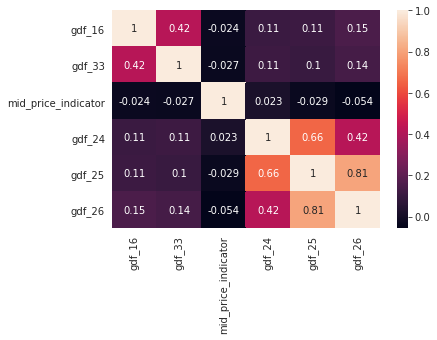

In [7]:
cols = feature_columns + ['mid_price_indicator'] + ['gdf_24', 'gdf_25', 'gdf_26']
print(cols)
sns.heatmap(df[cols].corr(), annot=True)

In [8]:
from sklearn.decomposition import PCA

X = df[[c for c in df.columns if 'gdf' in c]]
pca = PCA(n_components=3)
pca.fit(X)

X_transf = pca.transform(X)
res = {}
for C in [1000, 1100, 1500, 10000]:
    for g in [0.20, 0.25, 0.30]:
        clf = SVC(kernel='rbf', C=1000, gamma=g)
        scores = model.validate_model(clf, X_transf, df['mid_price_indicator'])
        df_score = pd.DataFrame(scores)
        res['C{}-g{}'.format(C, g)] = np.mean(df_score['matthews'].values)
res

{'C1000-g0.2': 0.04681968917600462,
 'C1000-g0.25': 0.04551718268124075,
 'C1000-g0.3': 0.04175684209104643,
 'C1100-g0.2': 0.04681968917600462,
 'C1100-g0.25': 0.04551718268124075,
 'C1100-g0.3': 0.04175684209104643,
 'C1500-g0.2': 0.04681968917600462,
 'C1500-g0.25': 0.04551718268124075,
 'C1500-g0.3': 0.04175684209104643,
 'C10000-g0.2': 0.04681968917600462,
 'C10000-g0.25': 0.04551718268124075,
 'C10000-g0.3': 0.04175684209104643}

In [9]:
dfs_reg[stock].head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2000,2013-09-10 13:29:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3334.5, 1486.0), (3335.0, 1968.0), (3335.5, ...",3333.0,3334.5,3333.75,1486.0,1241.0,0.0,-0.089842
2001,2013-09-10 13:30:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3333.0, 452.0), (3333.5, 1060.0), (3334.0, 1...",3332.0,3333.0,3332.50,452.0,1518.0,1.0,0.541117
2002,2013-09-10 13:31:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3333.5, 562.0), (3334.0, 1088.0), (3334.5, 2...",3332.5,3333.5,3333.00,562.0,1061.0,0.0,0.307455
2003,2013-09-10 13:32:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3333.5, 1398.0), (3334.0, 1390.0), (3334.5, ...",3332.0,3333.5,3332.75,1398.0,540.0,1.0,-0.442724
2004,2013-09-10 13:33:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3333.5, 870.0), (3334.0, 1372.0), (3334.5, 2...",3332.5,3333.5,3333.00,870.0,606.0,1.0,-0.178862


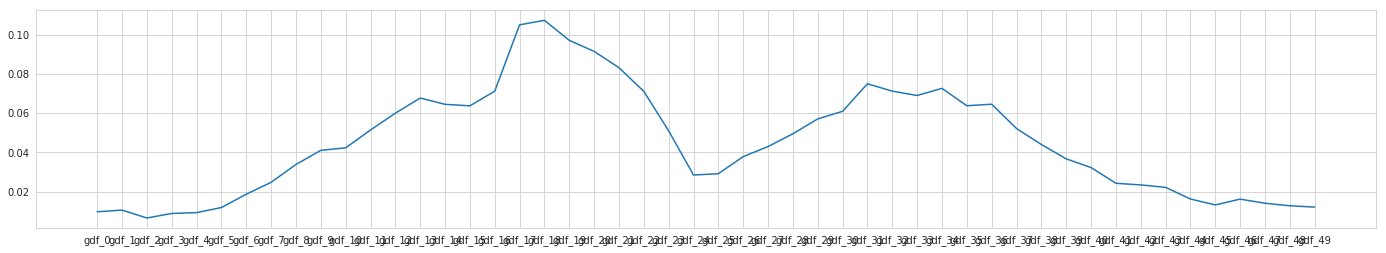

In [10]:
plt.figure(figsize=(24,4))
plt.plot(dfs[stock].iloc[2000][['gdf_{}'.format(i) for i in range(0, 50)]])


In [11]:
for stock in stocks:
    dfs[stock]['queue_imbalance'] = dfs_reg[stock]['queue_imbalance']
    dfs[stock]['prev_queue_imbalance'] = dfs[stock]['queue_imbalance'].shift()
    dfs[stock].dropna(inplace=True)
    dfs_test[stock]['queue_imbalance'] = dfs_reg_test[stock]['queue_imbalance']
    dfs_test[stock]['prev_queue_imbalance'] = dfs_test[stock]['queue_imbalance'].shift()
    dfs_test[stock].dropna(inplace=True)

['gdf_16', 'gdf_33', 'mid_price_indicator', 'gdf_24', 'gdf_25', 'gdf_26', 'queue_imbalance', 'prev_queue_imbalance']


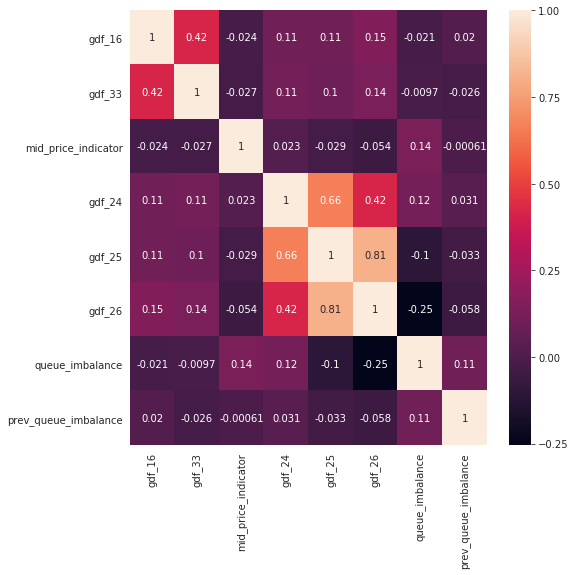

In [12]:
cols = feature_columns + ['mid_price_indicator'] + ['gdf_24', 'gdf_25', 'gdf_26'] + ['queue_imbalance', 'prev_queue_imbalance']
print(cols)
plt.figure(figsize=(8,8))
sns.heatmap(dfs[stock][cols].corr(), annot=True)

In [13]:
feature_columns_dict = {
    'gdf_24-26_que_prev': ['gdf_24', 'gdf_25', 'queue_imbalance', 'prev_queue_imbalance'], 
    'que': ['queue_imbalance'],
    'que_prev': ['queue_imbalance', 'prev_queue_imbalance'],
    'gdf_24-26_que': ['gdf_24', 'gdf_25', 'queue_imbalance'],
    'gdf_23-27_que': ['gdf_23', 'gdf_24', 'gdf_25', 'gdf_26', 'queue_imbalance'],
    'gdf_23-27': ['gdf_23', 'gdf_24', 'gdf_25', 'gdf_26'],
    'gdf_24_26': ['gdf_24', 'gdf_25'],
    'pca_gdf': ['gdf_{}'.format(i) for i in range(0, 50)],
    'pca_gdf_que': ['gdf_{}'.format(i) for i in range(0, 50)] + ['queue_imbalance'],
    'pca_gdf_que_prev': ['gdf_{}'.format(i) for i in range(0, 50)] + ['queue_imbalance', 'prev_queue_imbalance'],
    'gdf_20_30': ['gdf_{}'.format(i) for i in range(20, 30)],
    'gdf_20_30_que': ['gdf_{}'.format(i) for i in range(20, 30)] + ['queue_imbalance'],
    'gdf_20_30_que_prev': ['gdf_{}'.format(i) for i in range(20, 30)] + ['queue_imbalance', 'prev_queue_imbalance']
}
res = []
for stock in stocks:
    df = dfs[stock]
    df_test = dfs_test[stock]
    print(stock)
    for k, v in feature_columns_dict.items():
        C = 1
        gamma = 1
        train_x = df[v]
        if 'pca' in k:
            X = df[v]
            for i in range(2, 10):
                pca = PCA(n_components=i)
                pca.fit(X)
                train_x = pca.transform(X)
                clf = SVC(kernel='sigmoid')
                scores = model.validate_model(clf, train_x, df['mid_price_indicator'])
                df_score = pd.DataFrame(scores)
                res.append({'matthews': np.mean(df_score['matthews'].values), 
                        'stock': stock,
                        'C': C,
                        'gamma': gamma,
                        'features': k + str(i)
                       })
                continue
        clf = SVC(kernel='rbf', C=C, gamma=gamma)
        scores = model.validate_model(clf, train_x, df['mid_price_indicator'])
        #scores_test = model.test_model(clf, df_test[feature_columns], df_test['mid_price_indicator'])
        df_score = pd.DataFrame(scores)
        res.append({'matthews': np.mean(df_score['matthews'].values), 
                    #'matthews_test': scores_test['test_matthews'],
                    'stock': stock,
                    'C': C,
                    'gamma': gamma,
                    'features': k
                   })
df_results = pd.DataFrame(res)

9064
9061
9265


In [16]:
df_results.sort_values(by='matthews', ascending=False).groupby('stock').head(1)

,C,features,gamma,matthews,stock
91,1,pca_gdf_que3,1,0.124131,9265
56,1,pca_gdf_que5,1,0.097524,9061
28,1,pca_gdf_que_prev5,1,0.084726,9064


In [17]:
## let's train SVM!
stock = '9265'
df = dfs[stock]
res = []
for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    for g in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        for coef0 in [0.01, 0.1, 1, 10, 100]:
            clf = SVC(kernel='sigmoid', C=C, gamma=g, coef0=coef0)
            X = df[feature_columns_dict['pca_gdf_que']]
            pca = PCA(n_components=3)
            pca.fit(X)
            train_x = pca.transform(X)

            scores = model.validate_model(clf, train_x, df['mid_price_indicator'])
            df_score = pd.DataFrame(scores)
            res.append({'matthews': np.mean(df_score['matthews'].values), 
                        'stock': stock,
                        'C': C,
                        'coef0': coef0,
                        'gamma': g,
                        'features': feature_columns
                       })
df_results_9265 = pd.DataFrame(res)

In [18]:
df_results_9265.sort_values(by='matthews', ascending=False)

,C,coef0,features,gamma,matthews,stock
212,1000.00,1.00,"[gdf_16, gdf_33]",0.001,0.122388,9265
181,100.00,0.10,"[gdf_16, gdf_33]",0.010,0.121354,9265
180,100.00,0.01,"[gdf_16, gdf_33]",0.010,0.121171,9265
211,1000.00,0.10,"[gdf_16, gdf_33]",0.001,0.120887,9265
210,1000.00,0.01,"[gdf_16, gdf_33]",0.001,0.120856,9265
150,10.00,0.01,"[gdf_16, gdf_33]",0.100,0.119502,9265
215,1000.00,0.01,"[gdf_16, gdf_33]",0.010,0.117784,9265
177,100.00,1.00,"[gdf_16, gdf_33]",0.001,0.116834,9265
115,1.00,0.01,"[gdf_16, gdf_33]",0.100,0.116584,9265
176,100.00,0.10,"[gdf_16, gdf_33]",0.001,0.116560,9265


In [19]:
## let's train SVM!
stock = '9061'
df = dfs[stock]
res = []
for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    for g in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        for coef0 in [0.01, 0.1, 1, 10, 100]:
            clf = SVC(kernel='sigmoid', C=C, gamma=g, coef0=coef0)
            X = df[feature_columns_dict['pca_gdf_que']]
            pca = PCA(n_components=5)
            pca.fit(X)
            train_x = pca.transform(X)

            scores = model.validate_model(clf, train_x, df['mid_price_indicator'])
            df_score = pd.DataFrame(scores)
            res.append({'matthews': np.mean(df_score['matthews'].values), 
                        'stock': stock,
                        'C': C,
                        'coef0': coef0,
                        'gamma': g,
                        'features': feature_columns
                       })
df_results_9061 = pd.DataFrame(res)

In [20]:
df_results_9061.sort_values(by='matthews', ascending=False)

,C,coef0,features,gamma,matthews,stock
210,1000.00,0.01,"[gdf_16, gdf_33]",0.001,0.093988,9061
86,0.10,0.10,"[gdf_16, gdf_33]",1.000,0.093629,9061
180,100.00,0.01,"[gdf_16, gdf_33]",0.010,0.093480,9061
211,1000.00,0.10,"[gdf_16, gdf_33]",0.001,0.093480,9061
177,100.00,1.00,"[gdf_16, gdf_33]",0.001,0.093087,9061
176,100.00,0.10,"[gdf_16, gdf_33]",0.001,0.092933,9061
145,10.00,0.01,"[gdf_16, gdf_33]",0.010,0.092933,9061
115,1.00,0.01,"[gdf_16, gdf_33]",0.100,0.092642,9061
175,100.00,0.01,"[gdf_16, gdf_33]",0.001,0.092633,9061
146,10.00,0.10,"[gdf_16, gdf_33]",0.010,0.092034,9061


In [21]:
stock = '9064'
df = dfs[stock]
res = []
for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    for g in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        for coef0 in [0.01, 0.1, 1, 10, 100]:
            clf = SVC(kernel='sigmoid', C=C, gamma=g, coef0=coef0)
            X = df[feature_columns_dict['pca_gdf_que_prev']]
            pca = PCA(n_components=5)
            pca.fit(X)
            train_x = pca.transform(X)

            scores = model.validate_model(clf, train_x, df['mid_price_indicator'])
            df_score = pd.DataFrame(scores)
            res.append({'matthews': np.mean(df_score['matthews'].values), 
                        'stock': stock,
                        'C': C,
                        'coef0': coef0,
                        'gamma': g,
                        'features': feature_columns
                       })
df_results_9064 = pd.DataFrame(res)

In [22]:
df_results_9064.sort_values(by='matthews', ascending=False)

,C,coef0,features,gamma,matthews,stock
182,100.00,1.00,"[gdf_16, gdf_33]",0.010,0.090043,9064
150,10.00,0.01,"[gdf_16, gdf_33]",0.100,0.086730,9064
215,1000.00,0.01,"[gdf_16, gdf_33]",0.010,0.085037,9064
211,1000.00,0.10,"[gdf_16, gdf_33]",0.001,0.083796,9064
180,100.00,0.01,"[gdf_16, gdf_33]",0.010,0.083789,9064
210,1000.00,0.01,"[gdf_16, gdf_33]",0.001,0.083131,9064
181,100.00,0.10,"[gdf_16, gdf_33]",0.010,0.082651,9064
117,1.00,1.00,"[gdf_16, gdf_33]",0.100,0.082645,9064
116,1.00,0.10,"[gdf_16, gdf_33]",0.100,0.081325,9064
212,1000.00,1.00,"[gdf_16, gdf_33]",0.001,0.080843,9064


In [24]:
df_results_9061.to_csv('res_svm_training/res_overview_all_svm_gdf-small_s-sigmoid_kernel_{}.csv'.format(9061))
df_results_9064.to_csv('res_svm_training/res_overview_all_svm_gdf-small_s-sigmoid_kernel_{}.csv'.format(9064))
df_results_9265.to_csv('res_svm_training/res_overview_all_svm_gdf-small_s-sigmoid_kernel_{}.csv'.format(9265))
df_results.to_csv('res_svm_training/res_features_overview_all_svm_gdf-small_s-sigmoid_kernel.csv')